In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")    

In [2]:
from SBDHelper import SbdHelper
from TextCleaner import textCleaner
from WikiHelper import wikiHelper
import numpy as np
import neuralcoref
from spacy.tokens import Doc
from ARHelper import AnaphoraResolutionHelper

wiki = wikiHelper()
#text= wiki.GetLocalPage("Python_(programming_language)")
text= wiki.GetLocalPage("Sword_Art_Online")

#文本清理
tc=textCleaner(text)
cleanedText=tc.cleanText()

#---------- 斷句 --------------
if not nlp:
    nlp = spacy.load("en_core_web_sm")    
try:
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
except:
    pass
#--------- 合併斷句 ------------
sbd= SbdHelper()
Doc.set_extension("briefSents" , default=None , force=True)
try:
    nlp.add_pipe(sbd.briefSbd, after="sentencizer",name="sbd")
except:
    pass
    
doc= nlp(cleanedText)    

 #--------- 回指消解 ------------
Doc.set_extension("referedSents" , default=None , force=True)
print("--------- 回指消解 ------------")

nlp_ar= nlp
nlp_ar.remove_pipe('sbd')
try:
    neuralcoref.add_to_pipe(nlp_ar, name="neuralcoref",after="briefSents")    
except:
    pass
ar = AnaphoraResolutionHelper()    
try:
    nlp_ar.add_pipe(ar.arReplacement,name="arReplacement", after="neuralcoref")  
except:
    pass
    
print("has cor ",doc._.has_coref)
print("clusters ",doc._.coref_clusters)
    
clean_full_text= ""
for sent in doc._.briefSents[:]:
    sent_doc= nlp_ar(sent.text)
    print("------------------------------ ar 結果-----------------------------------------")
    clean_full_text+=sent_doc._.referedSents
    
print(clean_full_text)

TypeError: cleanText() missing 1 required positional argument: 'text'

In [ ]:
import numpy as np
from numpy.linalg import norm
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt

class LsaHelper:
    def __init__(self,doc):        
        self.words_count_dict={}#紀錄 <字,字數>的字典
        self.sentCount=0
        
        for sent in doc.sents:
            for word in sent:
                #不考慮stop word跟標點符號
                if word.is_stop or word.is_punct:
                    continue
                #剩下的加入字典                
                self.words_count_dict[word.lemma_.lower()]=0
                
                    
        #print(self.words_count_dict)
    
    def getSentencesImportence(self , sents):
        #Sentences embedding
        wcDicts=[]
        _sc= len(sents)
        #每個句子的word count dict
        for s in sents:
            _wcDict = self.getCooccDict(s.lemma_)
            wcDicts.append(_wcDict)
        #合併成一個matrix
        self.f , self.d = self.combineVecsToMatrix(wcDicts)
        #u,s,vh = self.featuresSVD(f)        
        
        #Sentences relativities matrix (填充句子關聯程度矩陣 )
        self.sents_cosSim = np.arange(_sc*_sc).reshape(_sc,_sc).astype(float)
        for i in range(0,_sc):
            for j in range(0,_sc):
                a= self.f[i]
                b=self.f[j]
                sim1_2 = (a@b) /(norm(a)*norm(b))
                self.sents_cosSim[i,j]=sim1_2
        
        #avg
        self.sents_avgSim= (self.sents_cosSim.sum(axis=1)-1)/(len(sents) - 1)
        return self.sents_avgSim
    def drawFeatureHeatMap(self):
        #熱圖
        fig, ax = plt.subplots()
        count=len(self.sents_avgSim)
        labels= ["S"+ str(i) for i in np.arange(count)]
        ax.set_xticks(np.arange(count), labels=labels)
        ax.set_yticks(np.arange(count), labels=labels)

        plt.imshow(self.sents_cosSim, cmap='cool', interpolation='nearest')
        plt.show()

    
    #取得該句子的共現向量
    def getCooccDict(self,sent):
        words= sent.lower().split()
        temp_dict = self.words_count_dict.copy()
        for word in words:
            if word in temp_dict:
                temp_dict[word]+=1
        return temp_dict
    
    def combineDictToMatrix(self,pairs):
        pair_coDicts =[]
        for pair in pairs:
            pair_coDicts.append(pair.coVector)
        dictvectorizer = DictVectorizer(sparse=False)
        features = dictvectorizer.fit_transform(pair_coDicts)
        #print(features)
        #print(dictvectorizer.get_feature_names())
        return features,dictvectorizer
    
    def combineVecsToMatrix(self,coVecs):
        pair_coDicts =[]       
        dictvectorizer = DictVectorizer(sparse=False)
        features = dictvectorizer.fit_transform(coVecs)
        #print(features)
        #print(dictvectorizer.get_feature_names())
        return features,dictvectorizer
    
    def featuresSVD(self, features):
        u,s,vh = np.linalg.svd(features)
        self.u=u
        self.s=s
        self.vh =vh
        return u,s,vh
                
    def getPassThreshold(self,targetRate):
        xlab = np.arange(0.01,0.99,step=0.05) 
        for x in xlab:            
            y= sum(self.sents_avgSim>=x)/len(self.sents_avgSim)
            if y<=targetRate:                
                return x
   

In [211]:
if __name__ =="__main__":
    import spacy
    nlp = spacy.load("en_core_web_sm")    
   
    doc= nlp(clean_full_text)

In [222]:

    lsa = LsaHelper(doc)    
    sents = list(doc.sents)
    
    lsa.getSentencesImportence(sents)
    print(lsa.sents_cosSim)
    
    #熱圖
    #lsa.drawFeatureHeatMap()
    
    print(np.round(lsa.sents_avgSim,3))
    

[[1.         0.56920998 0.43852901 ... 0.         0.         0.14142136]
 [0.56920998 1.         0.33282012 ... 0.         0.         0.        ]
 [0.43852901 0.33282012 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.57735027 0.25819889]
 [0.         0.         0.         ... 0.57735027 1.         0.        ]
 [0.14142136 0.         0.         ... 0.25819889 0.         1.        ]]
[0.085 0.077 0.074 0.012 0.055 0.056 0.065 0.047 0.054 0.052 0.037 0.027
 0.03  0.042 0.093 0.055 0.061 0.055 0.077 0.02  0.062 0.017 0.042 0.019
 0.022 0.041 0.045 0.027 0.059 0.026 0.034 0.02  0.026 0.017 0.021 0.018
 0.033 0.038 0.033 0.001 0.009 0.02  0.011 0.016 0.008 0.011 0.01  0.013
 0.023 0.025 0.049 0.069 0.044 0.059 0.012 0.062 0.042 0.053 0.057 0.041
 0.049 0.015 0.015 0.08  0.045 0.07  0.043 0.073 0.031 0.052 0.063 0.061
 0.075 0.076 0.02  0.003 0.024 0.035 0.019 0.013 0.071 0.019 0.018 0.042
 0.021 0.02  0.049 0.031 0.031 0.042 0.066 0.

In [223]:
print(sents[:5])

[
Sword_Art_Online  is a Japanese light novel series written by Reki Kawahara and illustrated by abec., a Japanese light novel series written by Reki Kawahara and illustrated by abec takes place in the near future and focuses on protagonists Kazuto "Kirito" Kirigaya and Asuna Yuuki as they play through various virtual reality MMORPG worlds., Kawahara originally wrote A live-action series as a web novel on Kawahara's websThe world, The world itselfselfe from 2002 to 2008., The light novels began publication on ASCII Media Works' Dengeki Bunko imprint from April 10, 2009, with a spin-off series launching in October 2012.]


In [224]:
#print( lsa.sents_cosSim)
print(np.sum(~np.isnan(lsa.sents_cosSim)))
lsa.sents_cosSim[np.isnan(lsa.sents_cosSim)]=0
print(np.sum(np.isnan(lsa.sents_cosSim)))
avg = lsa.sents_cosSim.sum(axis=1) / (len(sents)-1)
print(avg)

42849
0
[0.09034999 0.08209254 0.07869488 0.01654091 0.05993166 0.06126064
 0.06953644 0.05213525 0.05842877 0.05678713 0.04171683 0.03158597
 0.03533272 0.04670182 0.09795525 0.06026332 0.06599806 0.05979674
 0.08212572 0.0248752  0.06643901 0.02221524 0.04695344 0.02408425
 0.02694658 0.04626794 0.04972144 0.03141149 0.06346012 0.0309129
 0.0387239  0.02521601 0.03091451 0.02139253 0.02632763 0.02267459
 0.03820212 0.04319518 0.03739986 0.00603053 0.01415422 0.02456562
 0.01595417 0.02049618 0.01276094 0.0157548  0.0152577  0.0181741
 0.02788159 0.03023868 0.05348044 0.07377873 0.04922024 0.06342415
 0.01728315 0.06670899 0.04673175 0.05782364 0.0623452  0.04595157
 0.05374051 0.01936914 0.02026634 0.08449321 0.04942831 0.07474331
 0.04765872 0.07821239 0.03549358 0.05647263 0.0678523  0.06617954
 0.07954012 0.0810237  0.02487972 0.00784598 0.02840784 0.04002884
 0.02418651 0.01811391 0.07591195 0.02391988 0.02264986 0.04718399
 0.02626877 0.02521372 0.05423137 0.03620297 0.0357274  

In [235]:

the= lsa.getPassThreshold(0.25)
for i , val in enumerate(avg):
    if val>=the:
        print("接受",sents[i].text)
    else:
        print("拒絕 ", sents[i].text)

接受 
Sword_Art_Online  is a Japanese light novel series written by Reki Kawahara and illustrated by abec.
接受 a Japanese light novel series written by Reki Kawahara and illustrated by abec takes place in the near future and focuses on protagonists Kazuto "Kirito" Kirigaya and Asuna Yuuki as they play through various virtual reality MMORPG worlds.
接受 Kawahara originally wrote A live-action series as a web novel on Kawahara's websThe world
拒絕  The world itselfselfe from 2002 to 2008.
拒絕  The light novels began publication on ASCII Media Works' Dengeki Bunko imprint from April 10, 2009, with a spin-off series launching in October 2012.
接受 a spin-off series launching in October 2012 has spawned twelve manga adaptations published by ASCII Media Works and Kadokawa.
接受 The novels and the manga adaptations have been licensed for release in North America by Yen Press.

拒絕  An anime television series produced by A-1 Pictures, known simply as Sword_Art_Online, aired in Japan between July and Decemb

In [226]:
#接受率
the=0.86
print(sum(avg>=the) / len(avg))

0.0


In [227]:
#依保留率找到目標閥值
from scipy.optimize import minimize
def objective(avg,targetRate):
    v=lambda x: sum(avg>=x)/float(len(avg)) - targetRate
    return v

con1={"type":"ineq" , 'fun':con}

sol=minimize(objective(avg,0.1) ,1 , method='SLSQP',bounds=[(0.0,1.0)])
print(sol)
print(sol.x)

     fun: -0.1
     jac: array([-0.])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1.])
[1.]


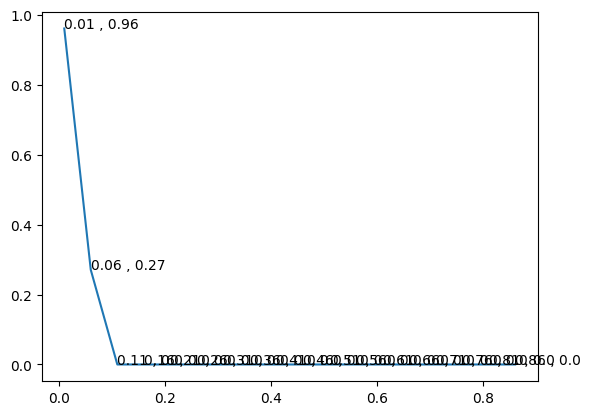

0.11


In [231]:
xlab = np.arange(0.01,0.9,step=0.05) #閥值
ylab=[]  #通過率
for x in xlab:
    ylab.append(sum(avg>=x)/len(avg))
    
plt.plot(xlab,ylab)
for a,b in zip(xlab, ylab): 
    plt.text(a, b, str(round(a,2))+" , "+str(round(b,2)))
plt.show()

target=0.1
for x in xlab:
    y= sum(avg>=x)/len(avg)
    if y<=target:
        print(x)
        break

In [229]:
lsa.getPassThreshold(0.1)

0.11